In [20]:
%load_ext snakeviz
%load_ext autoreload
%autoreload 2

import pickle
import multiprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import pearsonr

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
def discard_low_occurence(df, col, zero_thresh=2000):
    """ Reduce the size of the dataset by discarding features with lower frequency. 
        This is done by taking the first derivative of the distribution curve and trimming
        at a threshold for consecutive zeros (representing the point where the curve's steepness falls)
        
        Inputs:
            - df: input dataframe
            - col: feature used to crop data based on frequency
            - zero_thresh: number of consecutive zeroes to consider before trimming curve
            
        Returns:
            - df (dataframe): trimmed dataframe
        
        plots original distribution curve with red dot at the cutoff point
            
    """
    occurences = df[col].value_counts()
    # get threshold 
    d = np.diff(occurences.values)
    # find run starts
    loc_run_start = np.empty(d.shape[0], dtype=bool)
    loc_run_start[0] = True
    np.not_equal(d[:-1], d[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]
    # find run values
    run_values = d[loc_run_start]
    # find run lengths
    run_lengths = np.diff(np.append(run_starts, d.shape[0]))
    zero_runs_idx = np.where(run_values == 0)[0]
    thresh = np.argmax(run_lengths[zero_runs_idx] > zero_thresh)

    plt.plot(occurences.values[:])
    plt.plot(thresh, occurences.values[thresh], 'ro')

    mask = df[col].isin(occurences[:thresh].index.values)
    return df.loc[mask]

def df_to_relational_dict(df, key_col, feature_col):
    """ 
    Converts MovieLens dataframe to dictionary objects for faster parsing
    
    Inputs:
        - df (pd.DataFrame): input dataframe
        - key_col (String): Column to be used as key on the resulting dictionary
        - feature_col (String): Column to be used as value on the resulting dictionary
    
    Returns:
        - d (dict): dictionary with the format as follows:
        
            d = {
                <key>: 
                    'rating': list[],
                    'mean_rating': float,
                    <feature_col>: list[]                   
                
            }
    """
    df = df.set_index(key_col).sort_index()   
    keys, index = np.unique(df.index.values, True)
    keys = keys.astype(int)
    
    feature, ratings = df.values.T
    feat_arrays = np.split(feature.astype(np.uint8), index[1:])
    rating_arrays = np.split(ratings, index[1:])
    df = pd.DataFrame({key_col:keys, feature_col:[list(a) for a in feat_arrays],\
                       'rating':[list(a) for a in rating_arrays], 'mean_rating': [np.mean(a) for a in rating_arrays]})
    
    d = df.set_index(key_col).T.to_dict()
    return d

def build_deviation_dict(d, key_col, feature_col):
    """
    Pre-calculates deviations for the ratings
    
    Inputs:
        - d (dict): data dictionary obtained from relational dictionary
        - key_col (String): Column to be used as key 
        - feature_col (String): Column to be used as value 
    
    Returns:
        - deviations (dict): dictionary with pre-calculated deviations for ratings
        
    """
    deviations = {'key': key_col,
                 'feature': feature_col}
    
    for key in d:
        deviations[key] = {}
        entry = d[key]
        for feature in entry[feature_col]:
            rating_index = entry[feature_col].index(feature)
            rating = entry['rating'][rating_index]
            deviations[key][feature] = rating - entry['mean_rating']
            
        
    return deviations

def calc_weights(i, j):
    """
        Calculates Pearson's correlation coefficient between two entry 
        records. Output to be used as weight in the collaborative filtering algo.
        
        Inputs:
            - i (int): reference entry
            - j (int): comparison entry
        
        Returns:
            -r (float): pearson correlation coefficient between ratings
    """
    if (i == j):
        return 1.0
    
    i, deviations_i = list(train_deviations[i].keys()), list(train_deviations[i].values())
    j, deviations_j = list(train_deviations[j].keys()), list(train_deviations[j].values())
    
    # Skip if not enough overlapping movies
    overlap, overlap_idx_i, overlap_idx_j = np.intersect1d(i, j, return_indices=True)
    if len(overlap) < MIN_OVERLAP:
        return None
    # Compute (i,j) weight with pearsons corr. coeff.
    r, _ = pearsonr(np.array(deviations_i)[overlap_idx_i], np.array(deviations_j)[overlap_idx_j])
    return r

def build_weights_parallel(entries, train_dict, n_processes=8):
    """ 
        Parallelized pipeline to efficiently pre-calculate weights for larger data volumes.
        
        Inputs:
            - entries (list): list of keys to fetch feature values from data dictionary
            - train_dict (dict): data source
            -n_processes (int): number of processes to spawn. Best set to number of cores of the CPU
        
        Returns:
            - weights_dict (dict): pre-calculated symmetrical weight map for data set
    """
    rows = []

    with multiprocessing.Pool(PROCESSES) as pool:    
        for loop_idx, i in enumerate(tqdm(entries, position=0, leave=True)):
            row = []        
            for j in range(0, len(entries), PROCESSES*2):
                batch = entries[j:j+PROCESSES*2]
                res = [pool.apply_async(calc_weights, (i, j)) for j in batch]
                row += res

            rows.append([r.get() for r in row])
        pool.close()
        pool.join()
        
    index = list(train_dict.keys())
    weights_df = pd.DataFrame(rows, columns=index, index=index)
    weights_df = weights_df.where(pd.notnull(weights_df), None)
    weights_dict = weights_df.to_dict()
    return weights_dict

def predict(i, m):
    """ 
        Collaborative filtering prediction algorithm
        
        Inputs:
            - i (int): subject id of prediction
            - m (int): item id of prediction
        
        Returns:
            - pred (float): predicted deviation in relation to subject's average deviation
            
    """
    weighted_sum = 0
    w_i = limited_weights[i]
    mean_rating = train_dict[i]['mean_rating']
    
    for j in train_dict:
        try:
            w_ij = w_i[j]
            if w_ij is None:
                continue
    
            rating_deviation = train_deviations[j][m]
            weighted_sum += w_ij*rating_deviation
        except KeyError:
            continue
    return (weighted_sum + mean_rating)/abs(sum(w_i.values()))

def evaluate(d):
    mse = 0
    mae = 0
    n = 0
    for key in tqdm(d):
        for idx, feat in enumerate(d[key][FEATURE]):
            gt = d[key]['rating'][idx] - d[key]['mean_rating']
            pred = predict(key, feat)

            pred = min(5, pred)
            pred = max(0.5, pred)

            err = (pred - gt)        
            mae += err
            mse += err**2

            n += 1
    return mae, mse, n

# Preprocessing

In [43]:
raw_df = pd.read_csv("../movielens20M/rating.csv")
# Drop timestamp col
raw_df = raw_df.drop(['timestamp'], axis=1)

### Create subset by discarding low occurrence users

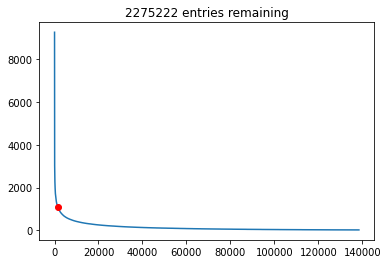

In [44]:
df = discard_low_occurence(raw_df, 'userId')
plt.title(f'{len(df)} entries remaining')
plt.show()

### Further reduce subset by discarding low occurrence movies

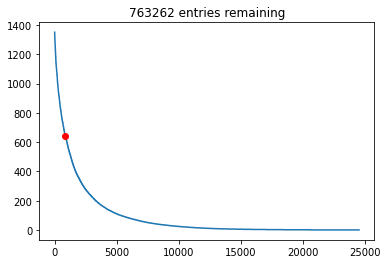

In [45]:
df = discard_low_occurence(df, 'movieId')
plt.title(f'{len(df)} entries remaining')
plt.show()

### Test/Train split

In [46]:
split_mask = np.random.rand(len(df)) < 0.8
train_df = df[split_mask]
test_df = df[~split_mask]

# Item-Item Colab. Filtering

In [47]:
KEY = 'movieId'
FEATURE = 'userId'

In [48]:
train_dict = df_to_relational_dict(train_df, key_col=KEY, feature_col=FEATURE)
test_dict = df_to_relational_dict(test_df, key_col=KEY, feature_col=FEATURE)

In [49]:
train_deviations = build_deviation_dict(train_dict, KEY, FEATURE)

### Precompute user-user weights

In [50]:
PROCESSES = 8
MIN_OVERLAP = 5

In [51]:
# %%snakeviz -t

entries = list(train_dict.keys())
weights = build_weights_parallel(entries, train_dict, PROCESSES)

100%|██████████| 852/852 [01:42<00:00,  8.31it/s]


 
*** Profile stats marshalled to file '/tmp/tmpwgn6cp0a'. 
Opening SnakeViz in a new tab...


### Prediction

In [53]:
# Limit to most important K neighbours
K = 25
limited_weights = {}
for key in weights:
    w_i = weights[key]
    limited_weights[key] = dict(sorted(w_i.items(), key=lambda x: abs(x[1]), reverse=True)[1:K+1])

### Evaluation

In [54]:
# %%snakeviz -t
mae, mse, n = evaluate(train_dict)
print(f"Train MAE: {mae/n:.04f}, MSE: {mse/n:.04f}, RMSE: {np.sqrt(mse/n):.04f}")
mae, mse, n = evaluate(test_dict)
print(f"Test MAE: {mae/n:.04f}, MSE: {mse/n:.04f}, RMSE: {np.sqrt(mse/n):.04f}")

  0%|          | 3/852 [00:00<00:32, 26.26it/s]

Train MAE: 0.8761, MSE: 1.7433, RMSE: 1.3203


100%|██████████| 852/852 [00:25<00:00, 33.17it/s]

Test MAE: 0.8755, MSE: 1.7935, RMSE: 1.3392


# User-User Colab. Filtering

In [57]:
KEY = 'userId'
FEATURE = 'movieId'

In [58]:
train_dict = df_to_relational_dict(train_df, key_col=KEY, feature_col=FEATURE)
test_dict = df_to_relational_dict(test_df, key_col=KEY, feature_col=FEATURE)

In [59]:
train_deviations = build_deviation_dict(train_dict, KEY, FEATURE)

### Precompute user-user weights

In [61]:
# %%snakeviz -t
entries = list(train_dict.keys())
weights = build_weights_parallel(entries, train_dict, PROCESSES)

100%|██████████| 1386/1386 [03:57<00:00,  5.83it/s]


### Prediction

In [63]:
# Limit to most important K neighbours
K = 25
limited_weights = {}
for key in weights:
    w_i = weights[key]
    limited_weights[key] = dict(sorted(w_i.items(), key=lambda x: abs(x[1]), reverse=True)[1:K+1])

### Evaluation

In [64]:
# %%snakeviz -t
mae, mse, n = evaluate(train_dict)
print(f"Train MAE: {mae/n:.04f}, MSE: {mse/n:.04f}, RMSE: {np.sqrt(mse/n):.04f}")
mae, mse, n = evaluate(test_dict)
print(f"Test MAE: {mae/n:.04f}, MSE: {mse/n:.04f}, RMSE: {np.sqrt(mse/n):.04f}")

  0%|          | 4/1386 [00:00<00:38, 35.93it/s]

Train MAE: 0.7308, MSE: 1.4695, RMSE: 1.2122


100%|██████████| 1386/1386 [00:40<00:00, 34.41it/s]

Test MAE: 0.7231, MSE: 1.4972, RMSE: 1.2236
